


The dataset was downloaded from [Maven Analytics](https://mavenanalytics.io/data-playground?search=chess) in August 2023.
It is a single .csv file containing information from around 20,000 chess games played on the Lichess app.

The dataset contains information about the winner of each game, the ratings of each player, and various descriptors of the opening line.
For any intermediate chess player looking to improve, studying openings and the associated theory is a common method. 
Practicing openings to discover their advantages and disadvantages is also common.

The analysis here looks into whether certain openings, as well as the relative player ratings, are predictive of Black or White winning (i.e. are certain openings better to play if you are playing that color?)

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import sklearn.metrics as skm

In [93]:
df = pd.read_csv("./chess_games.csv")

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_response   1207 non-null   object
 16  opening_variation  14398 non-null  objec

In [95]:
df.isna().sum()

game_id                  0
rated                    0
turns                    0
victory_status           0
winner                   0
time_increment           0
white_id                 0
white_rating             0
black_id                 0
black_rating             0
moves                    0
opening_code             0
opening_moves            0
opening_fullname         0
opening_shortname        0
opening_response     18851
opening_variation     5660
dtype: int64

Let's drop opening_variation and opening_response since they have a lot of NaNs, and also drop id variables

In [96]:
drop_cols = ['game_id', 'white_id', 'black_id',
             'opening_response', 'opening_variation']
df_clean = df.drop(drop_cols, axis=1)

For the other columns describing openings, let's check how many categories we might need if using them as a feature

In [97]:
opening_df = df_clean.loc[:, df_clean.columns.str.contains("opening")]
opening_df.nunique()

opening_code          365
opening_moves          23
opening_fullname     1477
opening_shortname     128
dtype: int64

Opening_moves is a numerical value, the number of moves which constitute the opening, so doesn't really belong here. It's also probably not going to be informative as a feature, since it is simply a descriptor of how many moves are generally considered part of the opening, but tells us nothing about the position or state of play.

The full names of the opening are varied enough that there are 1477 different categories, so there might not be enough observations per category. Perhaps the short name or the codes will be more useful. 

Before building a model, let's inspect the dataset a bit further

#### Calculate some descriptive statistics and make some data visualizations

In [98]:
df_clean.groupby("winner")['winner'].count()
# df_clean.groupby("winner")['winner'].count() / len(df) * 100  # to view as percentage

winner
Black     9107
Draw       950
White    10001
Name: winner, dtype: int64

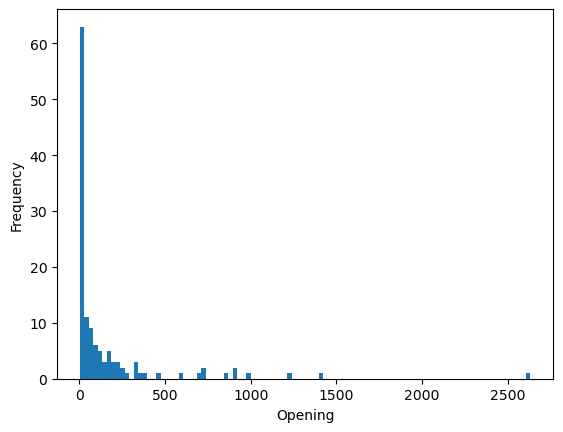

In [99]:
# plot histogram of openings frequencies

opening_counts = df_clean.groupby("opening_shortname")['opening_shortname'].count().sort_values()
ax = opening_counts.plot(kind='hist', bins=100)
ax.set_xlabel('Opening');

So there's a relatively even balance of White and Black wins, with just under 5% of games ending in a draw. On the other hand, the histogram of opening names shows that there are a small selection of very popular ones, and a lot of rarely-played openings.
To reduce the feature space, and ensure we are able to glean useful insights, let's set a threshold, and only keep openings with a sufficient frequency in the dataset.

Picking n_games = 100 leaves 40 openings. This seems like a more reasonable number to start with. Using .isin and .loc, select the games from the full dataframe which have one of these 40 openings.

In [100]:
n_games = 100

print(f"{(opening_counts>=n_games).sum()} openings occur at least {n_games} times in the dataset")

openings_to_keep = opening_counts[opening_counts>=n_games].index
df_short = df_clean.loc[df['opening_shortname'].isin(openings_to_keep)]
print(f"{len(df_short)} games started with one of these {(opening_counts>=n_games).sum()} openings")
print(f"The most popular opening is the {opening_counts.index[-1]}, played {opening_counts.iloc[-1]} times")

40 openings occur at least 100 times in the dataset
17924 games started with one of these 40 openings
The most popular opening is the Sicilian Defense, played 2632 times


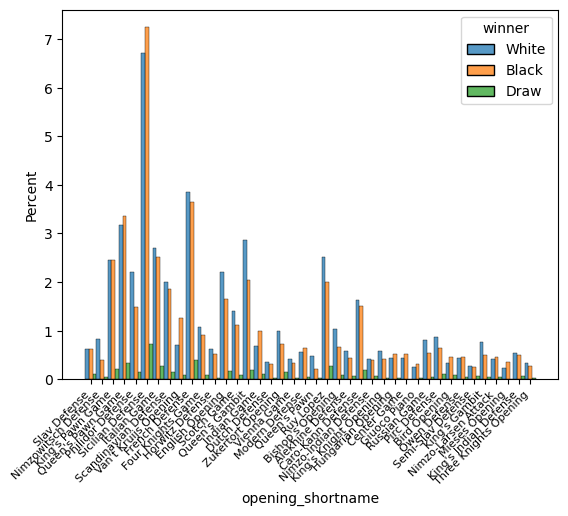

In [101]:
fig, ax = plt.subplots()
sns.histplot(
    data=df_short,
    x="opening_shortname",
    hue="winner",
    ax=ax,
    multiple='dodge',
    discrete=True, 
    stat='percent',

)
ax.set_xticks(range(len(openings_to_keep)),
              labels=df_short['opening_shortname'].drop_duplicates(),
              fontsize=8, rotation=45, ha='right');

Let's also drop the draws...for now

In [102]:
has_winner = df_short['winner'].isin(['White', 'Black'])
df_short = df_short.loc[has_winner, :]

Create a single feature reflecting the rating difference between white and black

In [103]:
df_short['rating_diff'] = (df_short['white_rating'] - df_short['black_rating']) / (df_short['white_rating'] + df_short['black_rating'])

In [104]:
X = df_short[['opening_shortname', 'rating_diff']]
y = df_short['winner']

y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [105]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), ['opening_shortname'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression())
])

In [106]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['opening_shortname'])])),
                ('logreg', LogisticRegression())])

In [107]:
y_pred = pipeline.predict(X_test)

In [108]:
print(f"Accuracy is {skm.accuracy_score(y_test, y_pred):.3f}")


Accuracy is 0.651


In [109]:
tn, fp, fn, tp = skm.confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

965 712 480 1259


We can use sklearn functions for these metrics, but let's do them by hand to reinforce what they mean


In [110]:
accuracy = (tn+tp) / (tn+fp+fn+tp)  # how often is the model correct in its prediction?
precision = tp / (tp+fp)  # precision: how often does model correctly predict positive?  or minimizing type I error rate
recall = tp / (tp+fn)   # recall: how well does model identify all positive cases ("sensitivity"), or minimizing type II error rate
print(accuracy, precision, recall)

0.6510538641686182 0.6387620497209539 0.7239792984473835


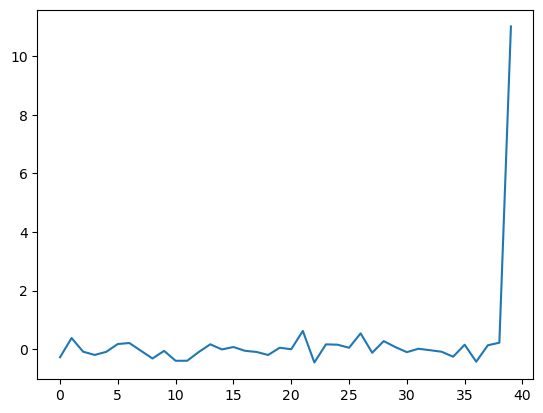

In [111]:
logreg = pipeline.named_steps['logreg']
plt.plot(logreg.coef_[0]);

So, it looks like we get accuracy, precision, and recall all in the 65-75% range. Given that we had a good class balance, accuracy might be good enough as a key metric. False positives and false negatives are probably equally undesirable.

Looking at the logistic regression coefficients, it's clear that the rating difference has an order of magnitude larger coefficient than any of the categorically defined openings. This suggests that rating difference is the dominant factor in deciding who wins. But even with this feature, the accuracy is not that great.

To explore on the modelling side:
1. Using opening codes instead of opening names. The opening codes come from the Chess Encyclopedia and follow a letter-number pattern, with letters from A-E denoting 5 classes of game (flank openings, semi-open games, open games, closed games, and Indian Defences). This would reduce the feature space to 5 categories.
2. Alternative classification models e.g. SVM, random forest

1. To use opening codes instead of opening names, let's re-use the original full size dataset

In [112]:
has_winner = df['winner'].isin(['White', 'Black'])
df2 = df.loc[has_winner, :]

In [113]:
# extract letter from opening_code

df2['opening_volume'] = df2['opening_code'].apply(lambda x: x[0])

/var/folders/r2/84czjx9n3_lfq5zrt533kb2w0000gn/T/ipykernel_40479/156054774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['opening_volume'] = df2['opening_code'].apply(lambda x: x[0])


In [114]:
df2['opening_volume'].drop_duplicates()   # 5 opening volumes, A-E

0     D
1     B
2     C
10    A
63    E
Name: opening_volume, dtype: object

In [115]:
# raw and normalized rating difference
df2['rating_diff'] = (df2['white_rating'] - df2['black_rating']) 
df2['rating_diff_norm'] = df2['rating_diff'] / (df2['white_rating'] + df2['black_rating'])

# and fit another logistic regression
X = df2[['opening_volume', 'rating_diff_norm']]
y = df2['winner']

y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(drop='first'), ['opening_volume'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

/var/folders/r2/84czjx9n3_lfq5zrt533kb2w0000gn/T/ipykernel_40479/2481078406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['rating_diff'] = (df2['white_rating'] - df2['black_rating'])
/var/folders/r2/84czjx9n3_lfq5zrt533kb2w0000gn/T/ipykernel_40479/2481078406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['rating_diff_norm'] = df2['rating_diff'] / (df2['white_rating'] + df2['black_rating'])


In [116]:
tn, fp, fn, tp = skm.confusion_matrix(y_test, y_pred).ravel()
accuracy = (tn+tp) / (tn+fp+fn+tp)  # how often is the model correct in its prediction?
precision = tp / (tp+fp)  # precision: how often does model correctly predict positive?  or minimizing type I error rate
recall = tp / (tp+fn)   # recall: how well does model identify all positive cases ("sensitivity"), or minimizing type II error rate
print(accuracy, precision, recall)

0.6616954474097331 0.6553267681289168 0.7367891293407146


Well, that doesn't help much. All our classification measures of performance (accuracy, precision and recall) are still hovering around 65-75%.

My intuition and background knowledge tells me it is likely a combination of rating, opening, AND those player's previous experiences/win %s with the opening that might serve as a better feature set for predicting the winners.

The vanilla Logistic Regression also cannot account for non-linear interactions between features, so we might also want to turn to alternative classification models.


Alas, there are a large number of unique players, and it seems the maximum number of times a single player appears in the dataset is 2, so we are unlikely to be able to calculate a reliable feature from player performances with different openings.

In [117]:
player_ids = pd.concat([df['white_id'], df['black_id']]).drop_duplicates()
player_ids.groupby(level=0).count().max()

2

In [118]:
# visualize win proportion vs rating difference, for each opening code category
df2[['winner','opening_volume','rating_diff_norm','rating_diff', 'white_rating','black_rating']].head()
df2.loc[:, 'winner'] = df2.loc[:, 'winner'].replace(to_replace={'White': 1, 'Black': 0})

/var/folders/r2/84czjx9n3_lfq5zrt533kb2w0000gn/T/ipykernel_40479/474379205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'winner'] = df2.loc[:, 'winner'].replace(to_replace={'White': 1, 'Black': 0})
/var/folders/r2/84czjx9n3_lfq5zrt533kb2w0000gn/T/ipykernel_40479/474379205.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df2.loc[:, 'winner'] = df2.loc[:, 'winner'].replace(to_replace={'White': 1, 'Black': 0})


Optimization terminated successfully.
         Current function value: 0.608682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626411
         Iterations 5


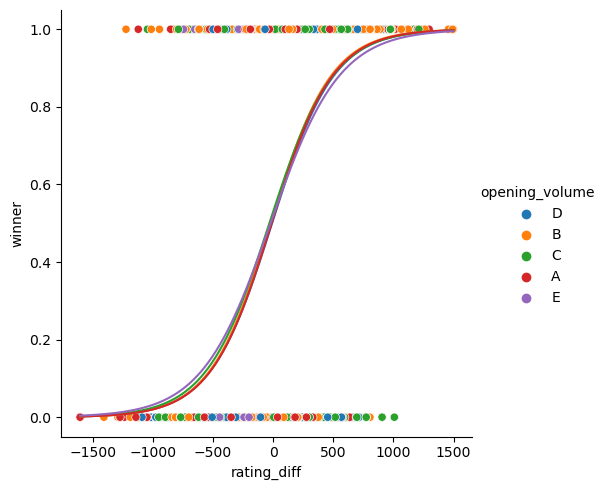

In [119]:
import numpy as np

df2[['winner','opening_volume', 'time_increment', 'rating_diff_norm','rating_diff', 'white_rating','black_rating']].head()

x_var = 'rating_diff'
hue = 'opening_volume'

sns.relplot(data=df2, x=x_var, y='winner', kind='scatter', hue=hue, palette='tab10')

xvals = np.linspace(df2[x_var].min(), df2[x_var].max(), 100)

# TODO need to specify colors here to match the scatter plot
for cat in np.unique(df2[hue]):
    logreg = sm.Logit(df2.loc[df2[hue]==cat, 'winner'], sm.add_constant(df2.loc[df2[hue]==cat, x_var])).fit()
    yhat = logreg.predict(sm.add_constant(xvals))
    plt.plot(xvals, yhat, label='Logistic fit')
plt.show()

Check performance with different classification models

In [120]:
models = [LogisticRegression(), SVC(), RandomForestClassifier()]

for model in models:

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"{type(model).__name__} accuracy: {skm.accuracy_score(y_test, y_pred):.10f}")


LogisticRegression accuracy: 0.6616954474
SVC accuracy: 0.6551543694
RandomForestClassifier accuracy: 0.6098901099


Overall, rating difference is a good predictor of winner (as one would expect), but overall accuracy, precision, or recall is not that strong. As can be seen from the scatter plot and logistic curve, there is a clear overlap in the categories. Additional features such as individual player's success with different openings and opening categories might facilitate a more accurate model, but aren't readily available in this dataset because there are not a lot of repeated occurrences of individual players.

It may also be worth exploring the influence of time increment, and subsetting wins into checkmates/resignations vs time losses. For simplicity here, all these were treated the same.